# Time Series Analysis of Crashes


## By

## Daniel Emaasit

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
# import theano
# import theano.tensor as tt
# import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
sns.set_context('notebook')
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [14, 6]}
sns.set(rc = rc)
sns.set_style("whitegrid")
import gpflow
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from gpflowopt.domain import ContinuousParameter
from gpflowopt.bo import BayesianOptimizer
from gpflowopt.acquisition import ExpectedImprovement
from gpflowopt.optim import SciPyOptimizer
from gpflowopt.optim import StagedOptimizer
from gpflowopt.optim import MCOptimizer

/Users/demaasit/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6



In [39]:
import rpy2
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings("ignore")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Data Preparation

In [5]:
monthly_crash_data = pd.read_csv("../../data/monthly_data.csv")
monthly_crash_data.head()

FileNotFoundError: File b'../../data/monthly_data.csv' does not exist

In [45]:
# Check the data types of each variable
monthly_crash_data.dtypes

Year               int64
Month              int64
Fatalities         int64
SeriousInjuries    int64
dtype: object

Create a new datetime column labelled "ds" that combines original columns "Year" and "Month"


In [46]:
from datetime import datetime
monthly_crash_data["ds"] = monthly_crash_data["Year"].map(str) + "-" + monthly_crash_data["Month"].map(str)
monthly_crash_data["ds"] = pd.to_datetime(monthly_crash_data["ds"])
monthly_crash_data["ds"] = monthly_crash_data.ds.astype("O")
monthly_crash_data.tail()

,Year,Month,Fatalities,SeriousInjuries,ds
235,2013,8,29,208,2013-08-01 00:00:00
236,2013,9,19,161,2013-09-01 00:00:00
237,2013,10,22,121,2013-10-01 00:00:00
238,2013,11,25,127,2013-11-01 00:00:00
239,2013,12,18,148,2013-12-01 00:00:00


In [47]:
# Check again the data types of each variable
monthly_crash_data.dtypes

Year                int64
Month               int64
Fatalities          int64
SeriousInjuries     int64
ds                 object
dtype: object

In [48]:
fatal_crash_data = monthly_crash_data[["ds", "Fatalities"]].rename(columns = {"Fatalities" : "y"})
fatal_crash_data.head()

,ds,y
0,1994-01-01 00:00:00,28
1,1994-02-01 00:00:00,17
2,1994-03-01 00:00:00,28
3,1994-04-01 00:00:00,24
4,1994-05-01 00:00:00,15


visualize fatal crashes

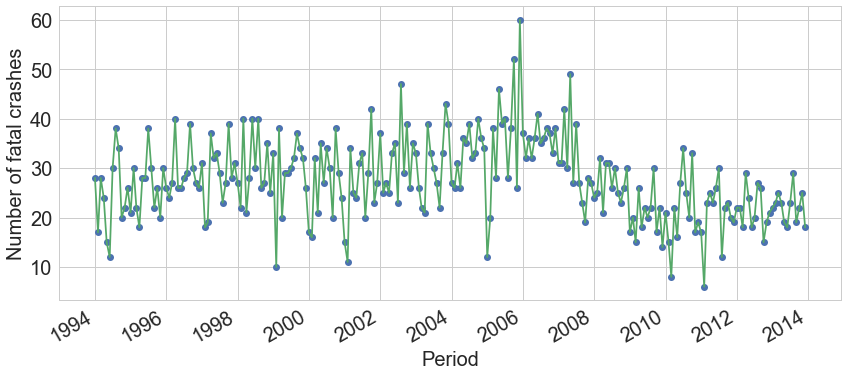

In [49]:
import matplotlib.dates as mdates
years = mdates.YearLocator(2, month = 1, day = 1)   # every year

fig, ax = plt.subplots()
ax.plot_date(x = "ds", y = "y", data = fatal_crash_data)
ax.plot(fatal_crash_data.ds, fatal_crash_data.y)
ax.xaxis.set_major_locator(years)

fig.autofmt_xdate()
ax.set_ylabel("Number of fatal crashes")
ax.set_xlabel("Period");

In [50]:
injury_crash_data = monthly_crash_data[["ds", "SeriousInjuries"]].rename(columns = {"SeriousInjuries" : "y"})
injury_crash_data.head()

,ds,y
0,1994-01-01 00:00:00,203
1,1994-02-01 00:00:00,162
2,1994-03-01 00:00:00,206
3,1994-04-01 00:00:00,187
4,1994-05-01 00:00:00,194


In [51]:
injury_crash_data[injury_crash_data.index == 192]

,ds,y
192,2010-01-01 00:00:00,171


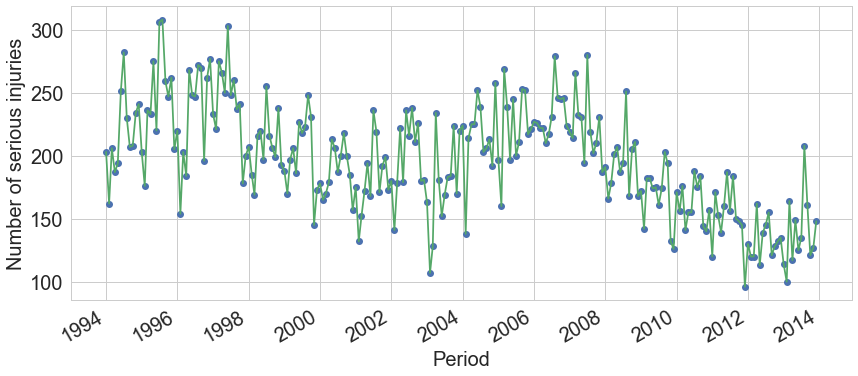

In [52]:
fig, ax = plt.subplots()
ax.plot_date(x = "ds", y = "y", data = injury_crash_data)
ax.plot(injury_crash_data.ds, injury_crash_data.y)
ax.xaxis.set_major_locator(years)

fig.autofmt_xdate()
ax.set_ylabel("Number of serious injuries")
ax.set_xlabel("Period");

In [53]:
X_complete = np.array([injury_crash_data.index]).reshape((240, 1)).astype('float64')
X_train = X_complete[0:203, ]
X_test = X_complete[204:240, ]
Y_complete = np.array([injury_crash_data.y]).reshape((240, 1)).astype('float64')
Y_train = Y_complete[0:203, ]
Y_test = Y_complete[204:240, ]
D = Y_train.shape[1];

In [54]:
D

1

In [55]:
Y_train.shape; X_train.shape; Y_test.shape; X_test.shape; X_complete.shape

(203, 1)

(203, 1)

(36, 1)

(36, 1)

(240, 1)

In [56]:
Y_train[0:3, ]; X_train[0:3, ]; X_test[0:3, ]; X_complete[0:3, ]

array([[ 203.],
       [ 162.],
       [ 206.]])

array([[ 0.],
       [ 1.],
       [ 2.]])

array([[ 204.],
       [ 205.],
       [ 206.]])

array([[ 0.],
       [ 1.],
       [ 2.]])

In [57]:
Y_train.dtype

dtype('float64')

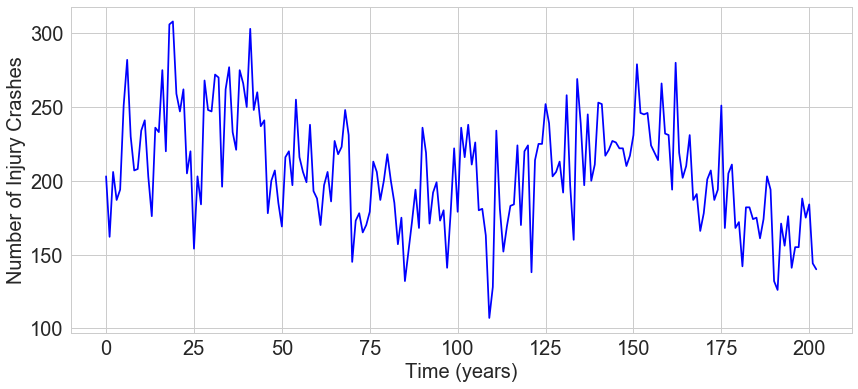

In [58]:
fig, ax = plt.subplots()
ax.plot(X_train.flatten(),Y_train.flatten(), c ='b')
# ax.set_xticklabels([1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010])
ax.set_xlabel('Time (years)')
ax.set_ylabel('Number of Injury Crashes');
# fig1 = plt.gcf()
# py.offline.iplot_mpl(fig1);

## Gaussian Process modeling

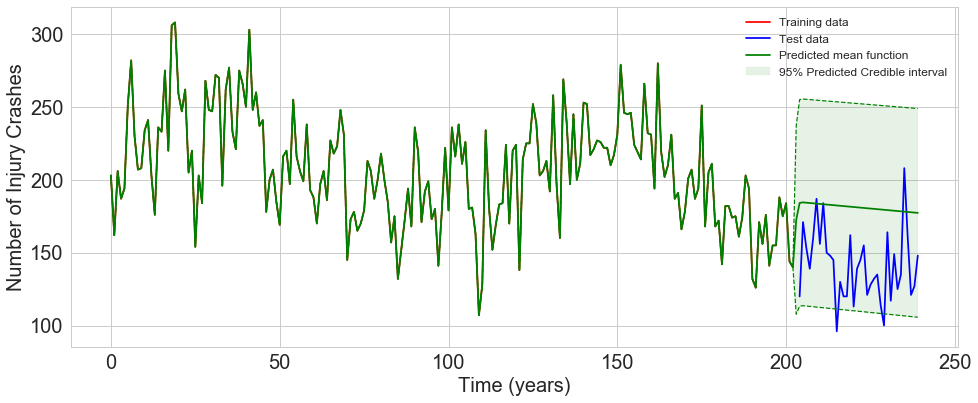

In [59]:
Q = 10 # nr of terms in the sum
max_iters = 1000

# Trains a model with a spectral mixture kernel, given an ndarray of 2Q frequencies and lengthscales
def create_model(hypers):
    f = np.clip(hypers[:Q], 0, 5)
    weights = np.ones(Q) / Q
    lengths = hypers[Q:]

    kterms = []
    for i in range(Q):
        rbf = gpflow.kernels.RBF(D, lengthscales=lengths[i], variance=1./Q)
        rbf.lengthscales.transform = gpflow.transforms.Exp()
        cos = gpflow.kernels.Cosine(D, lengthscales=f[i])
        kterms.append(rbf * cos)

    k = np.sum(kterms) + gpflow.kernels.Linear(D) + gpflow.kernels.Bias(D)
    m = gpflow.gpr.GPR(X_train, Y_train, kern=k)
    return m

def plotprediction(m):
    # Perform prediction
    mu, var = m.predict_f(X_complete)

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
#     ax.set_xticklabels([1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020])
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Number of Injury Crashes');
    ax.plot(X_train.flatten(),Y_train.flatten(), c='r', label = 'Training data')
    ax.plot(X_test.flatten(),Y_test.flatten(), c='b', label = 'Test data')
    ax.plot(X_complete.flatten(), mu.flatten(), c='g', label = "Predicted mean function")
    lower = mu - 2*np.sqrt(var)
    upper = mu + 2*np.sqrt(var)
    ax.plot(X_complete, upper, 'g--', X_complete, lower, 'g--', lw=1.2)
    ax.fill_between(X_complete.flatten(), lower.flatten(), upper.flatten(),
                    color='g', alpha=.1, label = "95% Predicted Credible interval")
    plt.legend(loc = "best")
    plt.tight_layout()

m = create_model(np.ones((2*Q,)))
m.optimize(maxiter=max_iters)
plotprediction(m);

In [23]:
from gpflowopt.objective import batch_apply

# Objective function for our optimization
# Input: N x 2Q ndarray, output: N x 1.
# returns the negative log likelihood obtained by training with given frequencies and rbf lengthscales
# Applies some tricks for stability similar to GPy's jitchol
@batch_apply
def objectivefx(freq):
    m = create_model(freq)
    for i in [0] + [10**exponent for exponent in range(6,1,-1)]:
        try:
            mean_diag = np.mean(np.diag(m.kern.compute_K_symm(X_train)))
            m.likelihood.variance = 1 + mean_diag * i
            m.optimize(maxiter=max_iters)
            return -m.compute_log_likelihood()
        except:
            pass
    raise RuntimeError("Frequency combination failed indefinately.")

# Setting up optimization domain.
lower = [0.]*Q
upper = [5.]*int(Q)
df = np.sum([ContinuousParameter('freq{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])

lower = [1e-5]*Q
upper = [300]*int(Q)
dl = np.sum([ContinuousParameter('l{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])
domain = df + dl
domain

Name,Type,Values
freq0,Continuous,[ 0. 5.]
freq1,Continuous,[ 0. 5.]
freq2,Continuous,[ 0. 5.]
freq3,Continuous,[ 0. 5.]
freq4,Continuous,[ 0. 5.]
freq5,Continuous,[ 0. 5.]
freq6,Continuous,[ 0. 5.]
freq7,Continuous,[ 0. 5.]
freq8,Continuous,[ 0. 5.]
freq9,Continuous,[ 0. 5.]


In [24]:
from gpflowopt.design import LatinHyperCube
from gpflowopt.acquisition import ExpectedImprovement
from gpflowopt import optim, BayesianOptimizer
design = LatinHyperCube(6, domain)
X = design.generate()
Y = objectivefx(X)

In [25]:
m = gpflow.gpr.GPR(X, Y, kern=gpflow.kernels.Matern52(domain.size, ARD=False))

In [26]:
ei = ExpectedImprovement(m)

In [ ]:
opt = optim.StagedOptimizer([optim.MCOptimizer(domain, 5000), optim.SciPyOptimizer(domain)])

In [ ]:
optimizer = BayesianOptimizer(domain, ei, optimizer=opt)

In [27]:
with optimizer.silent():
    result = optimizer.optimize(objectivefx, n_iter=24)

      fun: 959.7941293613452
 hess_inv: <43x43 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.51145957e-05,   5.46874755e-05,   2.12317682e-01,
         4.10816901e-03,  -5.51867876e-04,   4.32171280e-03,
        -0.00000000e+00,   1.20952228e-02,  -0.00000000e+00,
         7.23591195e-03,  -1.27127656e-02,  -1.27160348e-02,
        -1.35526939e-02,  -1.60854220e-02,  -3.67287111e-02,
         1.33785210e-04,  -1.97863311e-03,   2.25067896e-04,
        -2.34779685e-01,  -1.15591249e-02,  -1.39867401e-02,
        -1.00683448e-02,  -1.07925638e-02,  -4.69018644e-03,
        -7.32422496e-04,  -4.63330755e-03,   1.93891614e-02,
         5.98544972e-03,  -6.50926679e-04,   8.29435736e-03,
         3.38692551e-02,   1.81306194e-03,  -1.89492149e-03,
         3.06029027e-03,  -2.09526949e-03,   1.90279023e-03,
        -2.45885471e-02,   1.92571777e-03,  -1.17306678e-02,
         3.01907642e-03,  -1.85841357e-10,   2.91738239e-03,
         4.09044242e-04])
  message: b'CONVERGEN

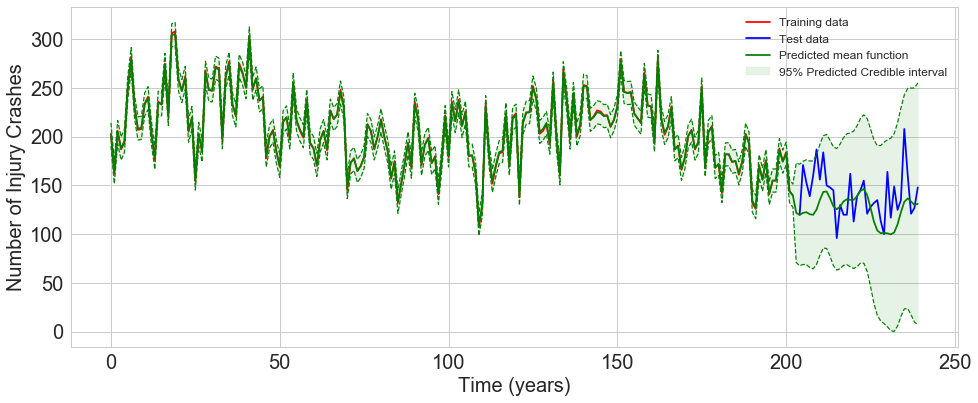

In [61]:
m = create_model(result.x[0,:])
m.optimize()

In [ ]:
plotprediction(m)

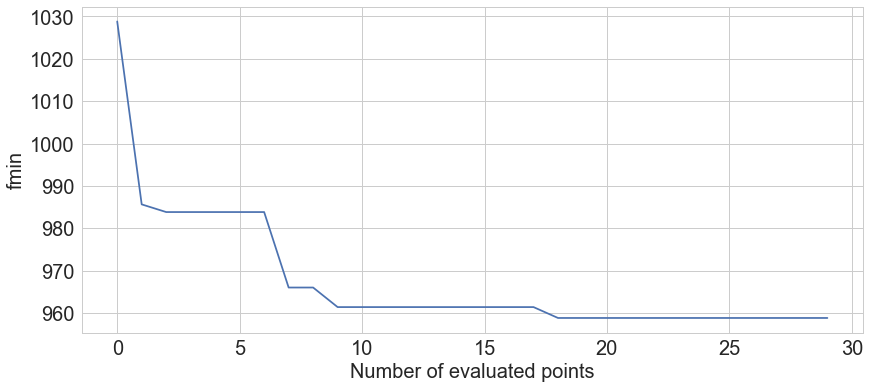

In [29]:
f, axes = plt.subplots()
f = ei.data[1][:,0]
axes.plot(np.arange(0, ei.data[0].shape[0]), np.minimum.accumulate(f))
axes.set_ylabel('fmin')
axes.set_xlabel('Number of evaluated points');

In [32]:
# save the model and results to the files 'model.pkl' and 'results.pkl' for later use
with open('model_optimized.pkl', 'wb') as mdl:
    pickle.dump(m, mdl, protocol = pickle.HIGHEST_PROTOCOL)
    
with open('result_optimized.pkl', 'wb') as res:
    pickle.dump(result, res, protocol = pickle.HIGHEST_PROTOCOL)    

In [60]:
# load it at some future point
with open('model_optimized.pkl', 'rb') as mdl:
    m = pickle.load(mdl)
    
with open('result_optimized.pkl', 'rb') as res:
    result = pickle.load(res)    